In [1]:
# Using python 3.9.6
import pandas as pd # pandas 1.3.3
from sklearn import svm # sklearn 0.0
import numpy as np # numpy 1.21.2
import matplotlib.pyplot as plt # matplotlib 3.4.3
from sklearn.utils import resample # sklearn 0.0
from sklearn.metrics import confusion_matrix # sklearn 0.0
import seaborn as sns # seaborn 0.11.2

In [34]:
# Import feature set; using a copy of the features from 032422. Code to generate these features
# can be found in the data_processing/make_features folder in this branch "compute_data_features".
df_main = pd.read_csv("~/human-activity-recognition/features_032422.csv")

# Making dictionary between incident id and category (i.e. slip, trip, fall, or other). 
# File path is to the raw data which the features were made from.
df_raw = pd.read_csv("~/human-activity-recognition/raw-data/har_raw.gz")

incident_dict = dict() # Dictionary with key = incident_id, and value = motion

for i in range(df_raw.shape[0]):
    incident_dict[df_raw.iloc[i,1]] = df_raw.iloc[i,2]

# Features that are going to be "ignored". Most of these features are based in the y-direction
# because the team found that models would correlate a "misoriented" wearable with a specific
# type of motion. (Alden mentioned it before in a meeting)
filter_feat = ["mean y","window -7480:-2480 mean y","window -4980:20 mean y","window -2480:2520 mean y",
               "window 20:5020 mean y","window 2520:7520 mean y","peak y"]

df_main.drop(filter_feat, axis=1, inplace=True) # remove selected features from the DataFrame
    
# z-score normalizes each feature to make sure the scales are the same (assume normal distribution)
for feature in df_main.columns:
    # Please do not normalize the incident_id values!
    if feature == "incident_id":
        continue
    df_main[feature] = (df_main[feature] - df_main[feature].mean())/df_main[feature].std()

# Separated dataframes for STF (slip, trip, falls) and Others
others = [ID for ID, motion in incident_dict.items() if motion == "other"]
stf = list(set(df_main["incident_id"])-set(others)) # Slip, trip, or fall IDs

df_stf = df_main[df_main["incident_id"].isin(stf)].reset_index().drop(labels=["index","incident_id"],axis=1)
df_other =df_main[df_main["incident_id"].isin(others)].reset_index().drop(labels=["index","incident_id"],axis=1)

# Remove the dataframes that will not be used (just to be clean)
del others; del stf; del df_raw;

In [12]:
def iter_SVM(df_other, df_stf, best_feat, iteration, n_other=df_stf.shape[0], n_stf=df_stf.shape[0]):
    '''
    # This function is meant to iterate through the feature list and apply forward feature selection to build
    # the best model that maximizes the model evaluation metric
    
    df_other (pd.DataFrame): dataframe containing all other-classified events
    df_stf (pd.DataFrame): dataframe containing all slip/trip/fall-classified events
    iteration (int): number of sampling iterations to find the best combination of features
    n_other (int): number of "other" data points to use to train model
    n_stf (int): number of "slip/trip/fall" data points to use to train model
    best_feat (list): labels of previous features that maximized the given training metric
    '''

    def _metric(df_stf,X_valid):
        '''
        # This is function is meant to generate whatever model selection metric that we want to base feature selection
        # off. Right now, it is implementing Positive Predictive Values (PPV; 02 24 2022)

        X_valid (multi-dimension array): contains data from the validation set
        '''
        return(df_stf.shape[0]/np.sum(lin_clf.predict(X_valid)))

    test_feat = list(set(df_stf.columns)-set(best_feat)) # list of features that we are testing
    
    # Dataframe that holds the feature evaluation metric for each iteration
    metric = pd.DataFrame(zip(test_feat,np.zeros(len(test_feat))),
                          columns=["feature","temp"]).set_index("feature")
        
    for reps in range(iteration):
        ### Want to use the same testing and validation set between evaluating features
       
        # Gets the row indices for the training data sets
        train_other = resample([i for i in range(df_other.shape[0])],n_samples=n_other) 
        train_stf = resample([i for i in range(df_stf.shape[0])],n_samples=n_stf)

        # Gets the row indices for the validation training set
        valid_other = [i for i in range(df_other.shape[0]) if i not in train_other]
        valid_stf = [i for i in range(df_stf.shape[0]) if i not in train_stf]
        
        # Adds on new column to store the PPV for the respective repetition
        _rep = "Rep. " + str(reps+1)
        metric = pd.concat([metric, pd.DataFrame(zip(test_feat,np.zeros(metric.shape[0])),columns=["feature",_rep]).set_index("feature")],axis=1)        
        
        for trial in test_feat:
            feature = best_feat + [trial] # feature list to train SVM with
            
            # Builds an feature list (X) and a list with their respective labels (Y).
            # For Y "values, 0 = others and 1 = Slip/Trip/Fall
            train_X = np.append(df_other.iloc[train_other,:][feature].to_numpy(), df_stf.iloc[train_stf,:][feature].to_numpy())
            train_Y = np.append(np.zeros(n_other),np.full((1,n_stf),1))
            valid_X = np.append(df_other.iloc[valid_other,:][feature].to_numpy(), df_stf.iloc[valid_stf,:][feature].to_numpy())
            
            train_X = train_X.reshape(-1,len(feature))
            valid_X = valid_X.reshape(-1,len(feature))
            
            # Training the Linear SVM
            lin_clf = svm.LinearSVC(dual=False,C=10,max_iter=10**5)
            lin_clf.fit(train_X,train_Y)
            
            # Adds performance metric to the DataFrame
            metric.loc[trial,_rep] = _metric(df_stf,valid_X)
    
    metric.drop("temp", axis=1, inplace=True) # drop the temporary column used for initialization
    avg_metric = metric.mean(axis=1) # averages metrics for the same feature
    maxed_feat = avg_metric.idxmax() # finds the best feature with the greatest averaged metric
    
    return (maxed_feat,metric)

The block of code below just finds the first "couple" top features that would be selected sequentially based on what maximized the performance metric PPV.

In [5]:
# Tunable Parameters
iterations = 100
n_others = 200 # number of other data points to train model with (default: df_stf.shape[0], matches maximum positive cases)
n_stf = 200 # number of slip, trip, fall data points to train model with (default: df_stf.shape[0], matches maximum positive cases)

PPV = [0] # Holds the PPV values as we successively add features using forward feature selection; needs to initialize with 0 to begin comparisons
best_feat = [] # Hold the features we add in chronological order

count = 0 # counter for the loop

# Loop iterates through all the features and stops when the model uses 20 features
# Gives an idea of how the model performs as we continue to add features to the SVM consecutively
for i in range(df_stf.shape[1]):
    top_feat, df_PPV = iter_SVM(df_other,df_stf,best_feat,iterations,n_others, n_stf)
    
    best_feat.append(top_feat)
    PPV.append(df_PPV.loc[top_feat].mean(axis=0))
    
    count += 1
    if count == 20:
        break

PPV.pop(0); # Removes the first indexed value because it was used as a placeholder for starting

Text(0.5, 1.0, 'Forward Feature Selection using a Linear Kernel SVM')

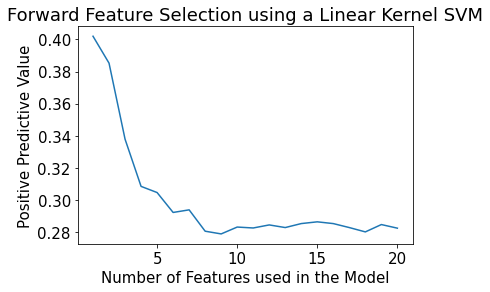

In [6]:
plt.rcParams.update({'font.size': 15})
plt.plot([i+1 for i in range(20)],PPV)
plt.xlabel("Number of Features used in the Model")
plt.ylabel("Positive Predictive Value")
plt.title("Forward Feature Selection using a Linear Kernel SVM")

In [16]:
# Let's see what the top 20 features would be if we only used ONE feature to predict classes
# using an SVM. Hopefully that will give insight about relationships between a single features
# and its predictive power...

top_feat, df_PPV_onefeat = iter_SVM(df_other,df_stf,[],iterations,n_others, n_stf)

top20_feat = df_PPV_onefeat.mean(axis=1).sort_values(ascending=False)[:20]

<AxesSubplot:title={'center':'PPV of the Top 20 Feature'}, ylabel='feature'>

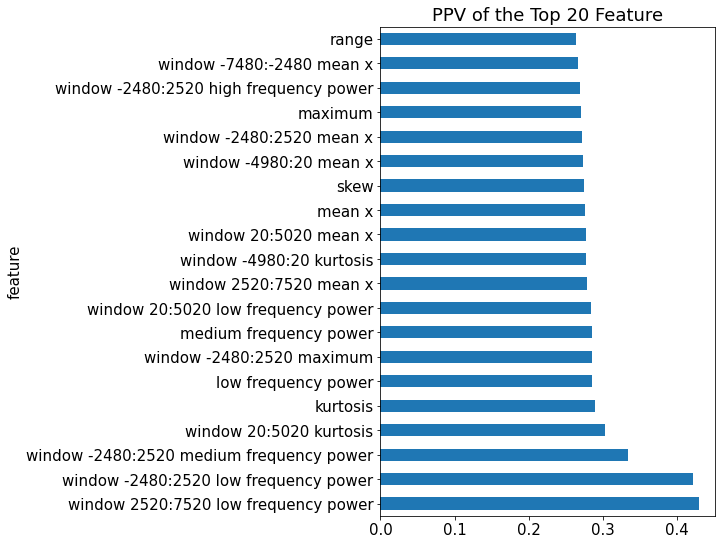

In [30]:
# Bar graph of top 20 features from an SVM trained with only one feature
top20_feat.plot.barh(figsize=[6,9],title="PPV of the Top 20 Feature")

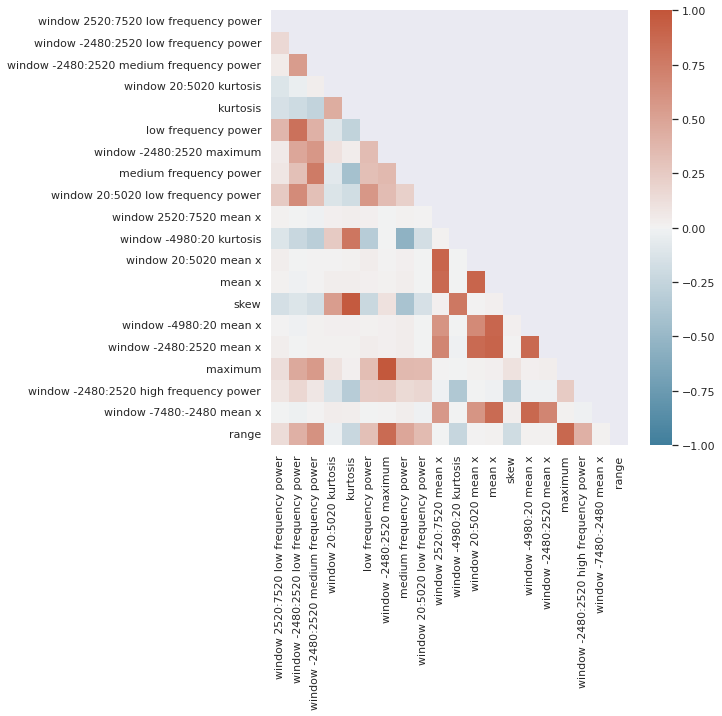

In [36]:
# Creates correlation heatmap of the top 20 features from an SVM trained with only one feature
corr = df_main[list(top20_feat.index)].corr() # correlation matrix

sns.set(rc = {'figure.figsize':(8,8)})
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr,mask=mask,cmap=cmap,vmin=-1,vmax=1)

This block of code below just does pure forward feature selection and stops when the performance metric (PPV) does not increase.

In [40]:
# Tunable Parameters
iterations = 300
n_others = 200 # number of other data points to train model with (default: df_stf.shape[0], matches maximum positive cases)
n_stf = 200 # number of slip, trip, fall data points to train model with (default: df_stf.shape[0], matches maximum positive cases)

PPV = [0] # Holds the PPV values as we successively add features using forward feature selection; needs to initialize with 0 to begin comparisons
best_feat = [] # Hold the features we add in chronological order

# Loop iterates through all the features, and breaks when the PPV no longer increases (onset of overfitting)
for i in range(df_stf.shape[1]):
    top_feat, df_PPV = iter_SVM(df_other,df_stf,best_feat,iterations,n_others, n_stf)
    
    best_feat.append(top_feat)
    PPV.append(df_PPV.loc[top_feat].mean(axis=0))
    
    print("Best Feature: %s, PPV: %.4f" %(top_feat,PPV[i+1]))

    # Checks if the new added feature increases PPV; else, break from loop
    if PPV[i+1] < PPV[i]:
        print("\nDone!")
        break

Best Feature: window -2480:2520 low frequency power, PPV: 0.4181
Best Feature: window 2520:7520 low frequency power, PPV: 0.4002

Done!
